In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
import tensorflow as tf

In [111]:
df = pd.read_csv("data.csv")
df = df.rename(columns={"tension_strenght": "tensile_strength"})
df.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        50 non-null     float64
 1   wall_thickness      50 non-null     int64  
 2   infill_density      50 non-null     int64  
 3   infill_pattern      50 non-null     object 
 4   nozzle_temperature  50 non-null     int64  
 5   bed_temperature     50 non-null     int64  
 6   print_speed         50 non-null     int64  
 7   material            50 non-null     object 
 8   fan_speed           50 non-null     int64  
 9   roughness           50 non-null     int64  
 10  tensile_strength    50 non-null     int64  
 11  elongation          50 non-null     float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.8+ KB


In [113]:
for column in df.columns:
    print(str(column)+": "+str(df[column].unique()))
    print()

layer_height: [0.02 0.06 0.1  0.15 0.2 ]

wall_thickness: [ 8  7  1  4  6 10  5  9  2  3]

infill_density: [90 80 70 40 10 20 50 30 60]

infill_pattern: ['grid' 'honeycomb']

nozzle_temperature: [220 225 230 240 250 200 205 210 215]

bed_temperature: [60 65 70 75 80]

print_speed: [ 40  60 120]

material: ['abs' 'pla']

fan_speed: [  0  25  50  75 100]

roughness: [ 25  32  40  68  92  60  55  21  24  30  75 118 200 220 126 145  88  74
 120 144 265 312 368 180 176 128 138 121 168 154 225 289 326 192 212 172
 163 276 298 360 357 321 278 244]

tensile_strength: [18 16  8 10  5 24 12 14 27 25 37  9 23 26 33 29 19 11 34 13 22  4 35 28
 21 30]

elongation: [1.2 1.4 0.8 0.5 0.7 1.1 1.3 1.5 1.7 2.4 1.  2.2 1.9 1.6 2.1 2.  0.9 0.4
 1.8 2.9 0.6 2.8 2.3 3.3 3.1 2.7 3.2]



In [114]:
#In this data set, ABS and PLA assigned 0 and 1 values for materials (abs = 0, pla = 1)
df.material = [0 if each=='abs' else 1 for each in df.material]

#In this data set, grid and honeycomb assigned 0 and 1 values for infill_pattern (grid = 0, honeycomb = 1)
df.infill_pattern = [0 if each=='grid' else 1 for each in df.infill_pattern]

df.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,0.02,8,90,0,220,60,40,0,0,25,18,1.2
1,0.02,7,90,1,225,65,40,0,25,32,16,1.4
2,0.02,1,80,0,230,70,40,0,50,40,8,0.8
3,0.02,4,70,1,240,75,40,0,75,68,10,0.5
4,0.02,6,90,0,250,80,40,0,100,92,5,0.7


In [115]:
df.layer_height = df.layer_height*100
df.elongation = df.elongation*100

In [116]:
df.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,2.0,8,90,0,220,60,40,0,0,25,18,120.0
1,2.0,7,90,1,225,65,40,0,25,32,16,140.0
2,2.0,1,80,0,230,70,40,0,50,40,8,80.0
3,2.0,4,70,1,240,75,40,0,75,68,10,50.0
4,2.0,6,90,0,250,80,40,0,100,92,5,70.0


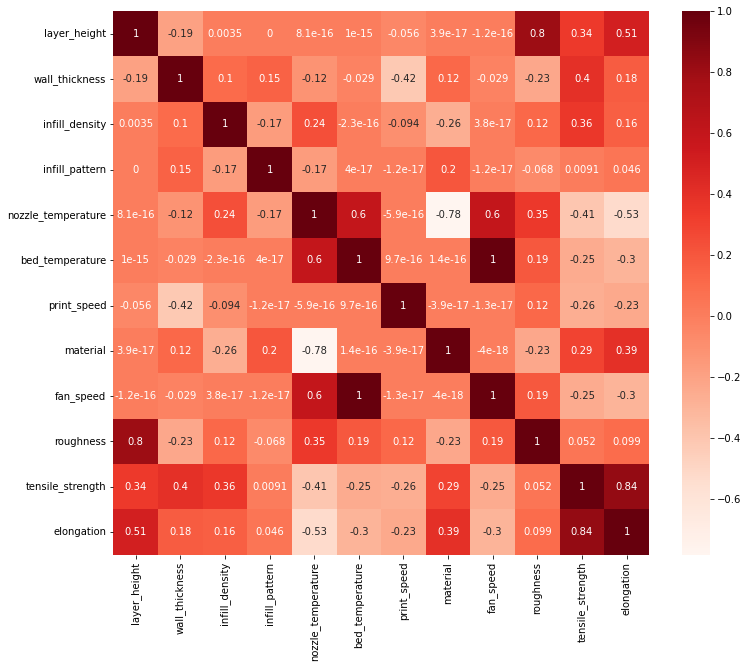

In [117]:
import seaborn as sns
plt.figure(figsize=(12,10))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds) #Using Pearson Correlation
plt.show()

In [15]:
target_cols = ['tensile_strength', 'roughness', 'elongation']
Y = df[target_cols].values
X = df.drop(target_cols,axis=1).values

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.09)
print(X_train.shape)
print(Y_test.shape)

(45, 9)
(5, 3)


In [101]:
# Construct a NN model using functional API
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Activation, Flatten

inputvec = Input( shape=(9,) )
x = Dense( 8, activation='relu' )(inputvec)
x = Dense( 16, activation='relu' )(x)
x = Dense( 32, activation='relu' )(x)
#x = Dropout(0.5)(x)
x = Dense( 16, activation='relu' )(x)
x = Dense( 8, activation='relu' )(x)
x = Dense( 4, activation='relu' )(x)
#x = Dropout(0.25)(x)
preds = Dense(3, activation='linear' )(x)

model_NN = Model(name= 'NN_model 1', inputs = inputvec,outputs=preds)
model_NN.summary()

Model: "NN_model 1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 9)]               0         
                                                                 
 dense_86 (Dense)            (None, 8)                 80        
                                                                 
 dense_87 (Dense)            (None, 16)                144       
                                                                 
 dense_88 (Dense)            (None, 32)                544       
                                                                 
 dense_89 (Dense)            (None, 16)                528       
                                                                 
 dense_90 (Dense)            (None, 8)                 136       
                                                                 
 dense_91 (Dense)            (None, 4)                 3

In [98]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

Epoch 1/1000
9/9 [==============================] - 1s 4ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 2/1000
9/9 [==============================] - 0s 4ms/step - loss: 24856.7676 - accuracy: 0.0000e+00
Epoch 3/1000
9/9 [==============================] - 0s 4ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 4/1000
9/9 [==============================] - 0s 4ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 5/1000
9/9 [==============================] - 0s 4ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 6/1000
9/9 [==============================] - 0s 4ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 7/1000
9/9 [==============================] - 0s 4ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 8/1000
9/9 [==============================] - 0s 4ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 9/1000
9/9 [==============================] - 0s 4ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 10/1000
9/9 [===========================

9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 154/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 155/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 156/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 157/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 158/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 159/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 160/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 161/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 162/1000
9/9 [=======================

Epoch 229/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 230/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 231/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 232/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 233/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 234/1000
9/9 [==============================] - 0s 4ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 235/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7676 - accuracy: 0.0000e+00
Epoch 236/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 237/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 238/1000
9/9 [========

Epoch 380/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 381/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 382/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 383/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 384/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 385/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 386/1000
9/9 [==============================] - 0s 4ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 387/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 388/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 389/1000
9/9 [========

Epoch 531/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 532/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 533/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 534/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 535/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 536/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 537/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 538/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 539/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 540/1000
9/9 [========

Epoch 682/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 683/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 684/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 685/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 686/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 687/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 688/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 689/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 690/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 691/1000
9/9 [========

Epoch 833/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 834/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 835/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 836/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 837/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 838/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 839/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 840/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 841/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 842/1000
9/9 [========

Epoch 984/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 985/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 986/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 987/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 988/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 989/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 990/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7617 - accuracy: 0.0000e+00
Epoch 991/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 992/1000
9/9 [==============================] - 0s 3ms/step - loss: 24856.7637 - accuracy: 0.0000e+00
Epoch 993/1000
9/9 [========

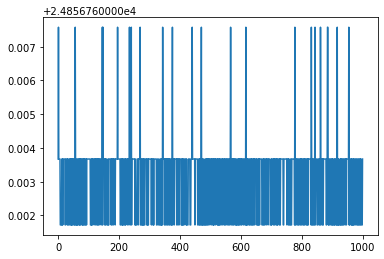

In [99]:
# Fit model to the data (train the model)
from keras.callbacks import History
history = History()

model.fit(X_train, Y_train, batch_size=5, epochs=1000, verbose=1, callbacks=[history])
# Batch size = 50 (all samples), epoch number = 10000 (the learning algorithm works through the entire dataset for 10000 times)
print('Done!')

# Plot the loss history
plt.plot(history.history['loss'])

Text(0, 0.5, 'mean squared error')

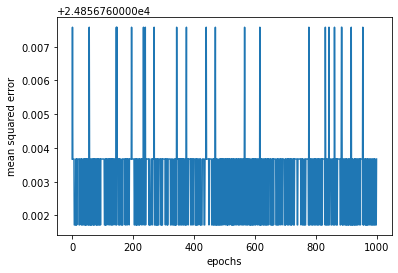

In [103]:
plt.plot(history.history['loss'],)
plt.xlabel("epochs")
plt.ylabel("mean squared error")

1/1 [==============================] - 0s 21ms/step - loss: 18028.1348 - accuracy: 0.0000e+00
[18028.134765625, 0.0]


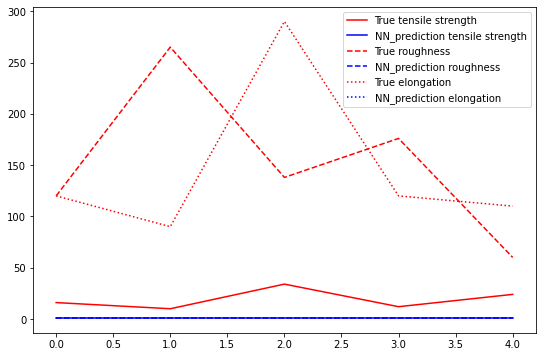

In [109]:
# Evaluate the accuracy of the model (loss: mean squared error, as defined in the step of compiling)
score = model.evaluate(X_test, Y_test, verbose=1)
print(score)

# Batch prediction & plot
Y_pred = model.predict(X_test)


plt.show()
plt.figure(figsize=(9, 6))
line1, = plt.plot(Y_test[:,0],'r-')
line2, = plt.plot(Y_pred[:,0],'b-')
line3, = plt.plot(Y_test[:,1],'r--')
line4, = plt.plot(Y_pred[:,1],'b--')
line5, = plt.plot(Y_test[:,2],'r:')
line6, = plt.plot(Y_pred[:,2],'b:')
plt.legend([line1, line2, line3, line4, line5, line6], ['True tensile strength', 'NN_prediction tensile strength', 'True roughness', 'NN_prediction roughness', 'True elongation', 'NN_prediction elongation'])